## scDEF on 3k PBMCs
scDEF is a statistical model that learns signatures of gene expression at multiple levels of resolution in an unsupervised manner. The model enables dimensionality reduction, clustering, and de novo signature identification from scRNA-seq data.

Here we apply scDEF to the 3k PBMCs data set from 10x Genomics used in the `scanpy` [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

### Load packages and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

import scdef

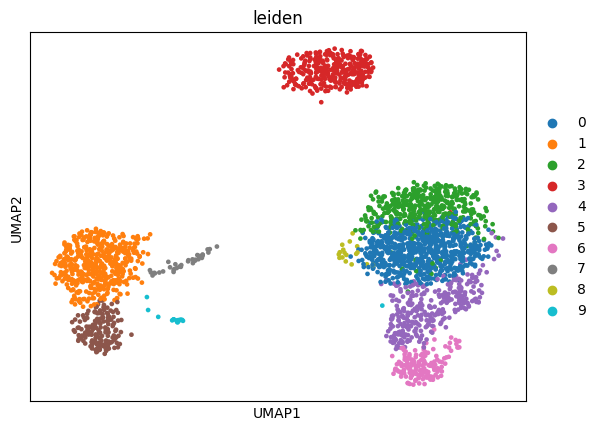

In [2]:
adata = sc.read_10x_mtx(
    'pbmcs_data/pbmcs3k/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata.obs.index = adata.obs.index.str.replace('-1', '')

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

adata.layers['counts'] = adata.X.toarray() # Keep the counts, for scDEF
adata.raw = adata

# Keep only HVGs
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.2) # Remove noisy genes but keep PBMCs markers

adata = adata[:, adata.var.highly_variable]

# Process and visualize the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

### Learn scDEF
By default scDEF uses three layers of sizes 100, 30, 10. Here we will only use two, for simplicity. We will also use only 1000 epochs instead of the default two rounds of 1000 epochs with decreasing learning rate.

In [3]:
scd = scdef.scDEF(adata, layer_sizes=[100, 30], counts_layer='counts') 
print(scd) # inspect the scDEF object, which contains a copy of the input AnnData

In [4]:
scd.learn() # learn the hierarchical gene signatures

INFO:scDEF:Initializing optimizer with learning rate 0.1 and annealing parameter 1.0
INFO:scDEF:Each epoch contains 1 batches of size 2638
100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s, Loss=2.15e+6]
INFO:scDEF:Initializing optimizer with learning rate 0.05 and annealing parameter 1.0
INFO:scDEF:Each epoch contains 1 batches of size 2638
100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s, Loss=2.11e+6]
INFO:scDEF:Updated adata.var: `gene_scale`
INFO:scDEF:Updated adata.obs with layer 0: `factor` and `z_<factor_idx>` for all factors in layer 0
INFO:scDEF:Updated adata.obsm with layer 0: `X_factors`
INFO:scDEF:Updated adata.obs with layer 1: `hfactor` and `hz_<factor_idx>` for all factors in layer 1
INFO:scDEF:Updated adata.obsm with layer 1: `X_hfactors`
INFO:scDEF:Updated adata.obs with layer 2: `hhfactor` and `hhz_<factor_idx>` for all factors in layer 2
INFO:scDEF:Updated adata.obsm with layer 2: `X_hhfactors`
INFO:scDEF:Updated scDEF graph


### Downstream analyses

#### Select relevant factors

By default, scDEF learns 100 factors at the highest resolution level. It also learns relevance estimates for each one, which we can use to filter out factors which have low relevance. Here we will keep only the factors whose relevances are at least 5 times the distance between the 3rd quartile and the median.

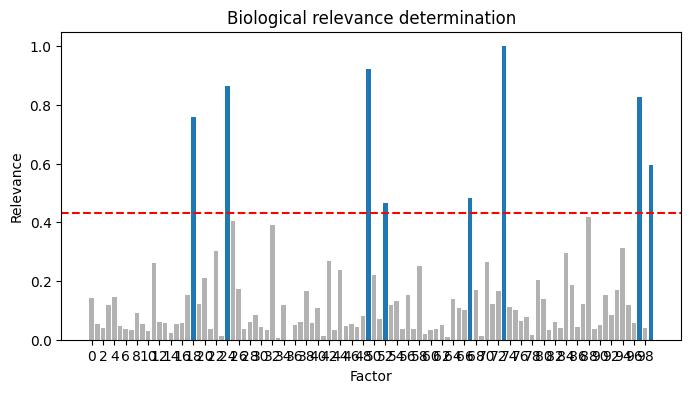

In [5]:
# See relevances
scd.plot_brd(iqr_mult=5, figsize=(8,4))

In [6]:
# Actually do the filtering
scd.filter_factors(iqr_mult=5.)

INFO:scDEF:Updated adata.var: `gene_scale`
INFO:scDEF:Updated adata.obs with layer 0: `factor` and `z_<factor_idx>` for all factors in layer 0
INFO:scDEF:Updated adata.obsm with layer 0: `X_factors`
INFO:scDEF:Updated adata.obs with layer 1: `hfactor` and `hz_<factor_idx>` for all factors in layer 1
INFO:scDEF:Updated adata.obsm with layer 1: `X_hfactors`
INFO:scDEF:Updated adata.obs with layer 2: `hhfactor` and `hhz_<factor_idx>` for all factors in layer 2
INFO:scDEF:Updated adata.obsm with layer 2: `X_hhfactors`
INFO:scDEF:Updated scDEF graph


#### Visualize scDEF graph

We can visualize the learned scDEF using `scd.make_graph`, which uses Graphviz to plot the scDEF graph.

INFO:scDEF:Updated scDEF graph


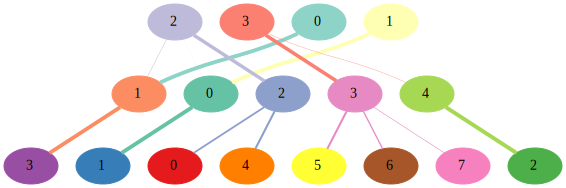

In [7]:
scd.make_graph(filled='factor', show_signatures=False) # simple graph with color-filled nodes
scd.graph # Graphviz object

And we can directly visualize the gene expression signatures associated with each factor at each level in the scDEF.

INFO:scDEF:Updated scDEF graph


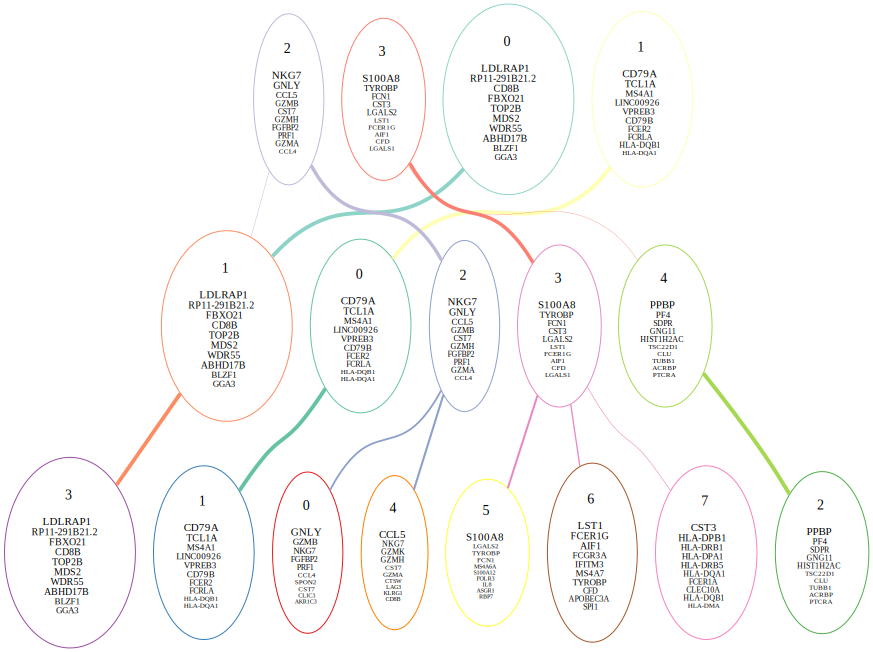

In [8]:
scd.make_graph(show_signatures=True) # simple graph with gene signatures in nodes
scd.graph

The graph shows the top scoring genes for each factor at the lowest layer, and their aggregations in the upper layers. For example, factors 2 and 7 in Layer 0 correspond to respectively, and they are aggregated in Layer 1. Similarly, factors 8 and 9 in Layer 0 correspond to T cell subtypes and they are aggregated in Layer 1.

The level of inheritance between layers can be controlled in the scDEF object parameters via `factor_shapes`. By default, these are set to `[1., .1, .1]`. To increase the level of inheritance, we can increase the Layer 1 and Layer 2 terms, for example to `[1., 10., 10.]`. The aggregations will then be stronger.

#### Visualize cell to factor assignments

scDEF assigns each cell to each factor at each level of resolution. We can visualize these assignments in the original UMAP.

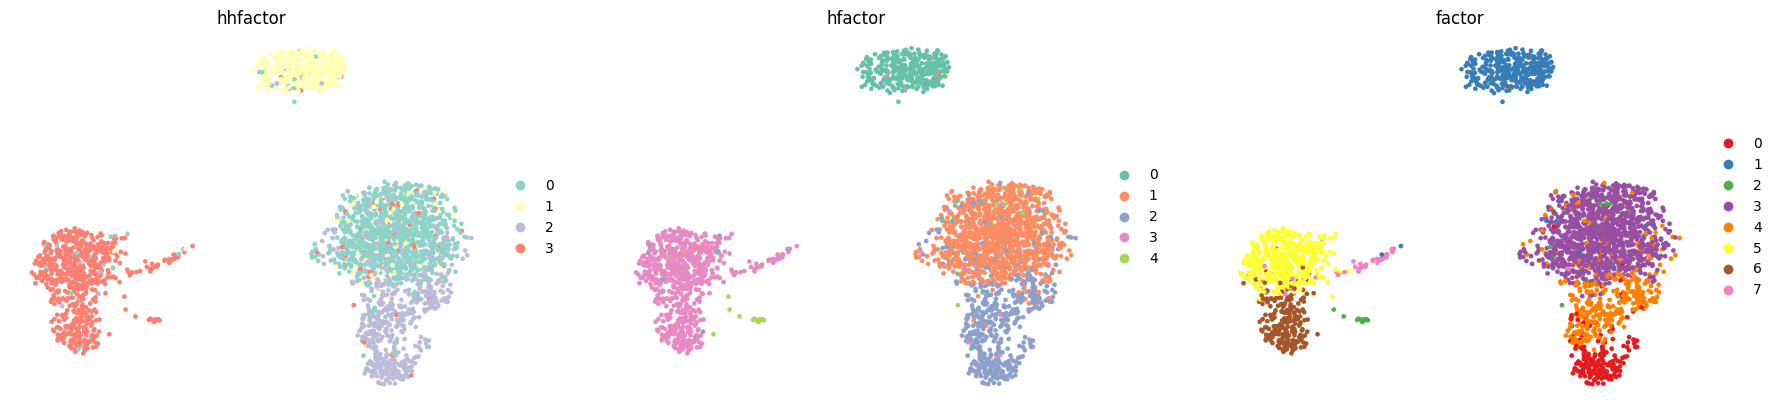

In [9]:
sc.pl.umap(scd.adata, color=['hhfactor', 'hfactor', 'factor'], frameon=False)

#### UMAP visualization of scDEF layers

Or we can use layers of scDEF to compute UMAP embeddings of cells for visualization, instead of relying on PCA as in the default scanpy pipeline. We take the logarithm of each of the new `obsm` in the `scd.adata` to deal with the sparse factors in scDEF that would otherwise lead to "wormy"-looking UMAPs.

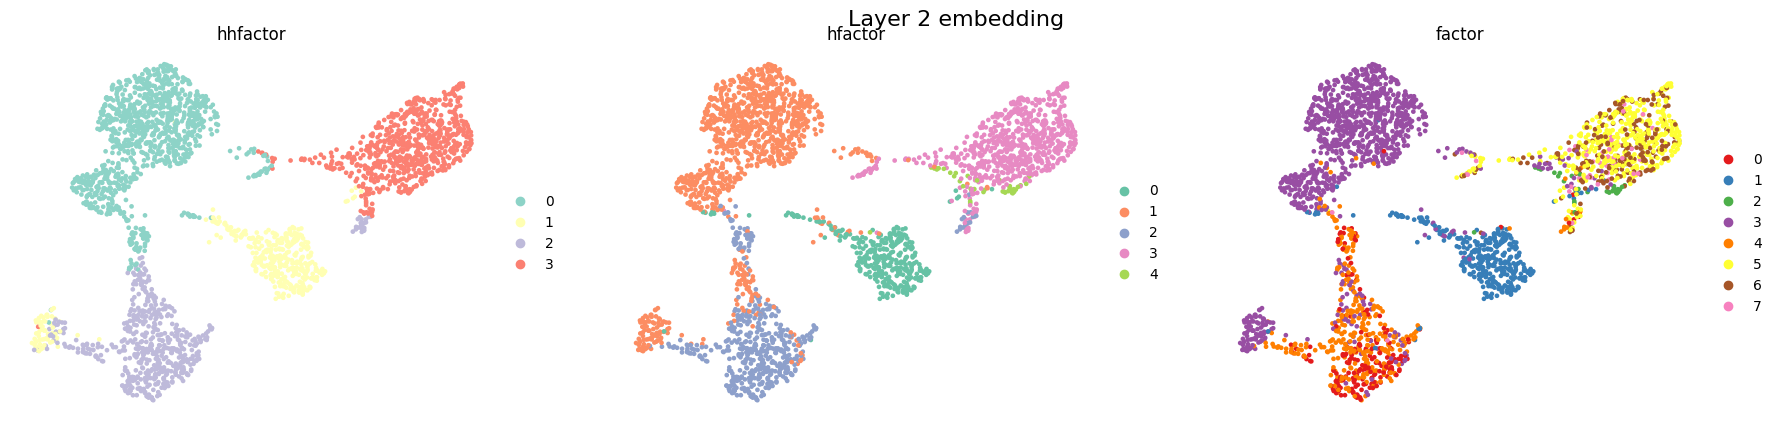

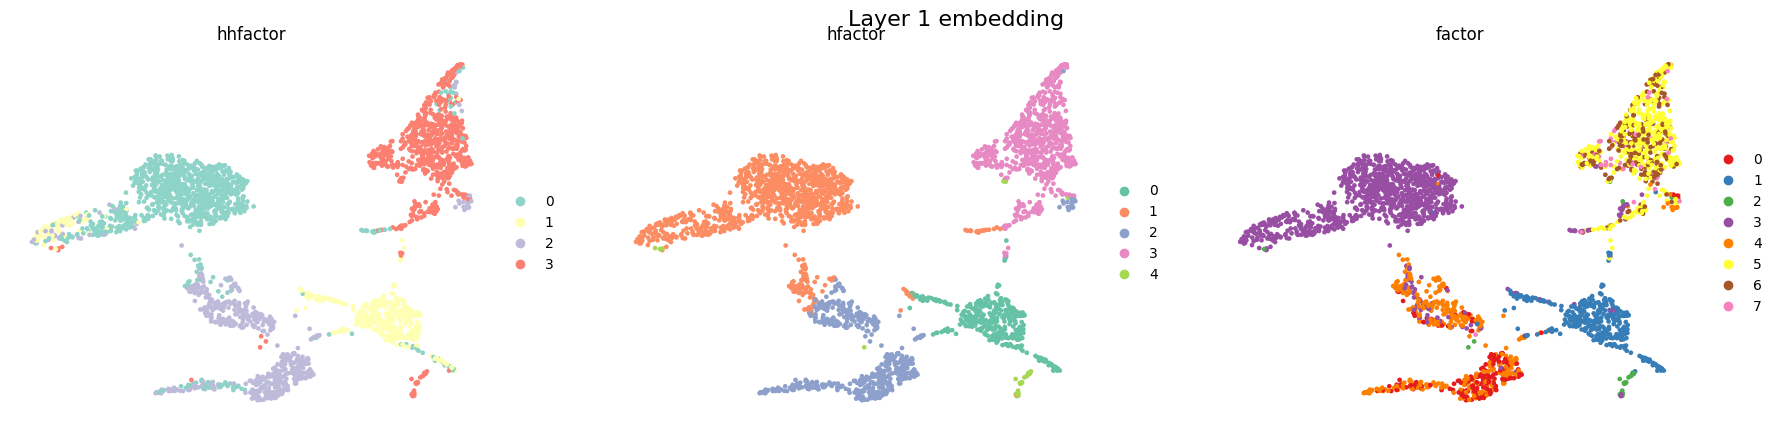

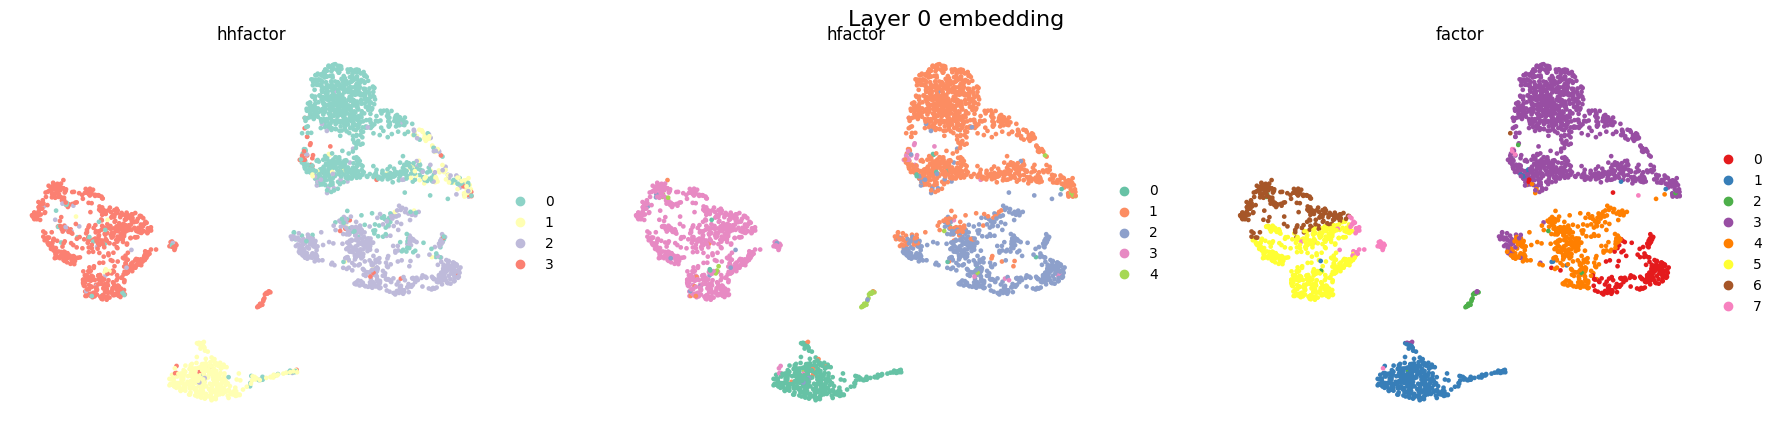

In [21]:
for layer in range(scd.n_layers-1, -1, -1):
    scd.adata.obsm[f'X_{scd.layer_names[layer]}factors_log'] = np.log(scd.adata.obsm[f'X_{scd.layer_names[layer]}factors'])
    sc.pp.neighbors(scd.adata, use_rep=f"X_{scd.layer_names[layer]}factors_log")
    sc.tl.umap(scd.adata)
    sc.pl.umap(scd.adata, color=['hhfactor', 'hfactor', 'factor'], frameon=False, show=False)
    plt.suptitle(f"Layer {layer} embedding", fontsize=16)
    plt.show()

#### Visualize PAGA graphs at the different scDEF layers

We can also visualize the multilayer structure of scDEF in a PAGA graph. This will show a graph representing the similarity between the factors at each layer. We can leverage the structure of the scDEF by initializing the graph at each layer `i` with the graph at layer `i+1` to keep them consistent across layers.

In [ ]:
scd.plot_multilevel_paga(figsize=(16,4), reuse_pos=True, frameon=False)

#### Visualize associations of factors with cell annotations

Finally, scDEF also comes with a utility function to plot associations between cell annotations and factors, using a dotplot. In a multi-batch setting, this is useful to check which factors are batch-specific. Here we simply compare the factors with the annotations provided by Leiden clustering, which is an `obs` in the `scd.adata` object.

In [ ]:
# Compare with leiden clusters
scd.plot_obs_factor_dotplot('leiden', 2, figsize=(16,3)) # layer 2
scd.plot_obs_factor_dotplot('leiden', 1, figsize=(16,3)) # layer 1
scd.plot_obs_factor_dotplot('leiden', 0, figsize=(16,3)) # layer 0